In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
from scipy.stats import kendalltau

from qbitmap import simulated_annealer
from qbitmap import utils
from qbitmap import postprocess
from qbitmap import io
from qbitmap.metrics import bootstrap_metric


In [3]:
# data structures
TIMESTAMP = "1627376744797"
DATESTR = "20210728"
N_STATES = 4
N_EXPERIMENTS = 148

# These arrays are shape `(N_EXPERIMENTS, 4, N_STATES)
# First axis corresponds to which path on hardware
# second axis has four entries:
#   0: F_LE
#   1: E[F]
#   2: Var[F]
#   3: F0, using no readout error
# Third axis corresponds to which computational basis state |j> was used
results_corr = np.load(f"./results/v3_hw_{DATESTR}_qft_line_results_corr.npy")
results_raw = np.load(f"./results/v3_hw_{DATESTR}_qft_line_results_raw.npy")

# This array is shaped `(N_EXPERIMENTS, 3)`
# The second axis is three pairs of (row, col) coordinates describing path placement
used_paths = np.load(f"./results/v3_hw_{DATESTR}_qft_line_paths.npy")


N_TRIALS = 5

# These arrays are shape `(N_EXPERIMENTS, N_TRIALS)`

# FLE_rand with depth= depth(U)
random_results_raw = np.load(f"./results/v3_hw_{DATESTR}_random_line_results_raw.npy")
random_results_corr = np.load(f"./results/v3_hw_{DATESTR}_random_line_results_corr.npy")

from qbitmap import postprocess
import os

# Load in a `(n_experiments, 2, n_qubits)` array of single qubit bitpflips.
readout_path = os.path.join(os.getcwd(), "readout_ec")
qvals_arr = postprocess.load_qvals_arr(timestamp=TIMESTAMP, n_experiments=N_EXPERIMENTS, path=readout_path)


In [5]:
# v4 data: full sweep, but no random
BF_REJECTION = 0.20

idx = postprocess.accept_by_bitflip(BF_REJECTION, qvals_arr)

all_paths = used_paths[idx]
FLE = results_corr[idx,0].mean(axis=1).flatten()
F0 = results_corr[idx,3].mean(axis=1).flatten()
F = results_corr[idx,1].mean(axis=1).flatten()

FLE_all = results_corr[idx,0].flatten()
F_all = results_corr[idx,1].flatten()
results = results_corr[:,[0,1,3],:].mean(axis=2)
results = results[idx,:]


# warning: 3rd index gets F0 now
F_LE_RAND_corr = random_results_corr[idx,:]
F_LE_RAND_corr_avg = random_results_corr[idx,:].mean(axis=1)
F_LE_RAND_corr_std = random_results_corr[idx,:].std(axis=1)

print("FLE:", scipy.stats.kendalltau(FLE_all, F_all))
print("FLE_rand:", scipy.stats.kendalltau(F_LE_RAND_corr_avg, F))
print("F0", scipy.stats.kendalltau(F0, F))

rejected 0 events for qmax>0.2
FLE: KendalltauResult(correlation=0.715690309598939, pvalue=1.6046596974175107e-149)
FLE_rand: KendalltauResult(correlation=0.453392167677882, pvalue=2.913368339038025e-16)
F0 KendalltauResult(correlation=0.14892443463872035, pvalue=0.007234992486460561)


In [6]:

parr = np.linspace(75, 90, 16)

x1 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(FLE, F, percentile) for percentile in parr])
x1_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, FLE, F, percentile, ntrials=200))
        for percentile in parr
])


x2 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F_LE_RAND_corr_avg, F, percentile) for percentile in parr])
x2_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F_LE_RAND_corr_avg, F, percentile, ntrials=200))
        for percentile in parr
])


x3 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F0, F, percentile) for percentile in parr])
x3_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F0, F, percentile, ntrials=200))
        for percentile in parr
])


x4 = 1 - parr/100


/tmp/ipykernel_7139/2779366102.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


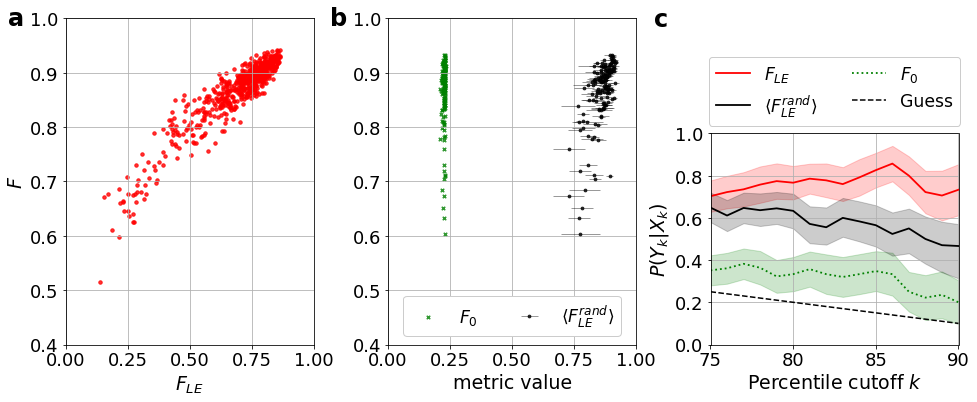

In [7]:
plt.style.use('../../style.mplstyle')
from scipy.stats import kendalltau
from qbitmap.metrics import bootstrap_metric

fig = plt.figure(figsize=(16, 6))

gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.3)
ax0 = fig.add_subplot(gs[0:3,0])
ax1 = fig.add_subplot(gs[0:3,1], sharey=ax0)
ax2 = fig.add_subplot(gs[1:3,2])
ax3 = fig.add_subplot(gs[1, 1])



plt.style.use('../../style.mplstyle')
s = 12 # dotsize
alpha = 0.8

# Compute correlation coefficients
r_FLE_F = kendalltau(FLE, F)[0]
r_F0_F = kendalltau(F0, F)[0]

ax0.scatter(FLE_all, F_all, label=r"$F_{LE}$", marker='o', c='r', alpha=alpha, s=s)

# ax0.set_ylabel(r"$F(U)$", size=22)
# xax = fig.add_subplot(111, frameon=False)
# xax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# xax.set_xlabel('Metric value', size=22)

for ax in [ax0, ax1]:
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0.4, 1)

ax0.set_ylabel("$F$")
ax0.set_xlabel("$F_{LE}$")
ax1.scatter(F0, F, label=r"$F_0$", marker='x', c='g', alpha=alpha, s=s)
ax1.set_xlabel("metric value")
ax1.errorbar(
    F_LE_RAND_corr_avg, 
    F, 
    linestyle="None", 
    xerr=F_LE_RAND_corr_std,
    label=r"$\langle F_{LE}^{rand} \rangle$",
    marker='o', 
    c='k', 
    markersize=np.sqrt(s)*.8, 
    alpha=alpha, 
    lw=.5)
ax1.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.5, 0), ncol=2)

# ax1.scatter(F_LE_RAND_corr_avg, F,  c='k', alpha=alpha, s=s)


percentiles_lw = 1.8
ax2.fill_between(parr, x1 -x1_err, x1 + x1_err, color='r', alpha=0.2)
ax2.fill_between(parr, x3 -x3_err, x3 + x3_err, color='g', alpha=0.2)
ax2.fill_between(parr, x2 -x2_err, x2 + x3_err, color='k', alpha=0.2)

ax2.plot(parr, x1, label=r"$F_{LE}$", color='r', alpha=1, ls='-', lw=percentiles_lw)
ax2.plot(parr, x2, label=r"$\langle F_{LE}^{rand} \rangle$", color='k', alpha=1, ls='-', lw=percentiles_lw)
ax2.plot(parr, x3, label=r"$F_0$", color='g', alpha=1, ls=':', lw=percentiles_lw)

ax2.plot(parr, x4, label="Guess", ls='--', c='k')

ax2.grid()
ax2.set_ylim(0, 1)
ax2.set_xlim(min(parr), max(parr))
ax2.set_ylabel(r"$P(Y_k | X_k)$")
ax2.set_xlabel(r"Percentile cutoff $k$")
ax2.legend(loc="center", bbox_to_anchor=(0.5, 1.2), framealpha=1, ncol=2)

ax3.axis('off')

# cAPTION
ax0.text(-0.2, 1, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax2.text(-0.2, 1.54, r"c", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")
ax1.text(-0.2, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")



plt.tight_layout()

# DRAFT
import os
DRAFT = False
if DRAFT:
    ax1.text(-.5,1.1, os.getcwd() + "/annealer_ghz_line_n4_scratchwork.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=ax.transAxes, weight="bold")
fig.savefig("../../figures/rainbow_qft_results.pdf",bbox_inches='tight')


In [8]:
# Analyze difference in FLE for every pair of nearby states
G = nx.Graph()
n_qubits = 3
for i, path_i in enumerate(all_paths):
    if (i % 100) == 0:
        print(i)
    F_LE, F, F0 = results[i]
    G.add_node(i, F_LE=F_LE, F=F)
    q_i =  set(tuple(map(tuple, path_i)))

    # Track the edges used, agnostic to ordering
    edges_i = [(tuple(path_i[k]), tuple(path_i[k+1])) for k in range(n_qubits - 1)]
    
    edges_i += [(t[1], t[0]) for t in edges_i]
    for j, path_j in enumerate(all_paths):
        if j <= i:
            continue
        q_j =  set(tuple(map(tuple, path_j)))
        edges_j = [(tuple(path_j[k]), tuple(path_j[k+1])) for k in range(n_qubits - 1)]
        edges_j += [(t[1], t[0]) for t in edges_j]
        
        # Number of shared qubits
        w_ij = len(q_i.intersection(q_j))
        # Number of shared edges
        ee_ij = len(set(edges_i).intersection(set(edges_j))) // 2
        
        G.add_edge(i, j, shared_edges=ee_ij, shared_nodes=w_ij)

0
100


In [9]:
FLE_by_weight = {} # weight=0, 1, 2, 3, 4 - 4 since i did actually run forwards and  backwards variations...
F_by_weight = {}
for (i, j, data) in G.edges(data=True):
    delta_FLE = G.nodes[i]['F_LE'] - G.nodes[j]['F_LE']   
    delta_F = G.nodes[i]['F'] - G.nodes[j]['F']
    (ns, es) = (data['shared_nodes'], data['shared_edges'])
    if not FLE_by_weight.get((ns, es)):
        FLE_by_weight[(ns, es)] = []
    if not F_by_weight.get((ns, es)):
        F_by_weight[(ns, es)] = []   
        
    FLE_by_weight[(ns, es)].append(delta_FLE)
    F_by_weight[(ns, es)].append(delta_F)

    
FLE_by_weight = {k: np.asarray(x) for (k, x) in FLE_by_weight.items()}
F_by_weight = {k: np.asarray(x) for (k, x) in F_by_weight.items()}

In [12]:
# Don't overwrite any of the analysis using a different processor...!
from qbitmap import calibration_data

TIMESTAMP = 1627376744797
target_calibration = PROCESSOR.get_calibration(TIMESTAMP // 1000) # UGHHHHH
print("TIMESTAMP:", TIMESTAMP)

# Target specifically these metrics
metric_1q = "single_qubit_rb_average_error_per_gate"
metric_2q = "two_qubit_sqrt_iswap_gate_xeb_average_error_per_cycle"
calibration = calibration_data.CalibrationWrapper(
    calibration_dct=target_calibration, 
    qubits=DEVICE.qubits, 
    metric_1q=metric_1q, 
    metric_2q=metric_2q
)
noise_graph = calibration.noise_graph


TIMESTAMP: 1627376744797


In [13]:
def T_exp(T0, alpha, steps):
    t = np.arange(steps)
    return T0 * alpha ** t

def T_log(T0, alpha, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * np.log(1 + t))

def T_poly(T0, alpha, p, steps):
    t = np.arange(steps)
    return T0 / (1 + alpha * t ** p)

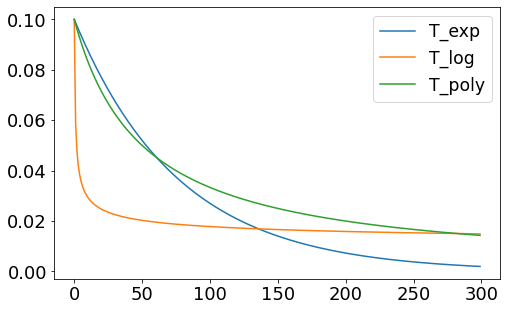

In [14]:
T0 = 0.1
p = 1
anneal_steps = 300

temps1 = T_exp(T0, 0.987, anneal_steps)
temps2 = T_log(T0, 1, anneal_steps)
temps3 = T_poly(T0, .02, p, anneal_steps)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(anneal_steps), temps1, label="T_exp")
ax.plot(range(anneal_steps), temps2, label="T_log")
ax.plot(range(anneal_steps), temps3, label="T_poly")
ax.legend(loc="upper right")

In [15]:
metric_results = results

trials = 20
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)
num_new_max_lst = [1] # FIXME: not configured for 3 new max
temps_lst = [temps1, temps2, temps3]

all_results = [ [ None for _ in range(len(temps_lst))] for _ in range(len(num_new_max_lst))]
all_state_counts = np.zeros((3, 3, trials))

for i, num_new_max in enumerate(num_new_max_lst):
    print("num_new_max= ", num_new_max)
    for j, temp in enumerate(temps_lst):
        print("temps= ", j)
        ann_results = []
        for ell in range(trials):
            idx_state = np.random.choice(len(all_paths))
            initial_state = all_paths[idx_state]
            annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
                initial_state=initial_state,
                paths=all_paths,
                fidelities=metric_results[:,0],
                graph=noise_graph,
                num_new_max=num_new_max,
                transition_probs=TRANSITION_PROBS,
                verbose=False
            )
            res, history = annealer.anneal(nsteps=anneal_steps, temperatures=temp)
            ann_results.append(history)
            all_state_counts[i,j,ell] = history['unique_states_counter'][-1]

        results_arr = np.zeros((trials, anneal_steps + 1))
        for k, res in enumerate(ann_results):
            results_arr[k,:] = res['score_history']
        all_results[i][j] = results_arr

num_new_max=  1
temps=  0
temps=  1
temps=  2
Stuck in a corner!


In [ ]:
fig, axes = plt.subplots(1 + len(num_new_max_lst), 3, figsize=(20, 12))
temp_labs = ["exp", "log", "poly"]
for i in range(len(num_new_max_lst) + 1):
    for j in range(len(temps_lst)):
        ax = axes[i, j]
        if i == 1:
            y = temps_lst[j]
            ax.plot(range(len(y)), y, c='k')
            ax.set_ylim(0, T0)
            continue
        results_arr = all_results[i][j]
        for k,res in enumerate(results_arr):
            ax.plot(range(anneal_steps+1), results_arr[k,:], lw=2, alpha=0.4, c='r')
#             ax.plot(range(anneal_steps+1), results_arr[k,:], lw=2, alpha=0.4, c='r')

        if j == 0:
            ax.set_ylabel("max_new={}".format(num_new_max_lst[i]))
        if i == 0:
            ax.set_title("Temp schedule: {}".format(temp_labs[j]))
#         ax.plot(range(anneal_steps), temps / max(temps), linewidth=1, c='k', ls=':')
        ax.set_xlim(-2, anneal_steps+2)
        ax.set_xticks(range(0, anneal_steps+1, 50))
        ax.set_xticklabels(range(0, anneal_steps+1, 50), fontsize=14)
        ax.set_xlabel('Annealer step $i$', fontsize=14)

        ax.set_ylim(0, 1.08)
        ax.set_ylim(0, max(results[:,0]))
        ax.set_yticks([.25, .5, .75, 1.])
        ax.set_yticklabels([.25, .5, .75, 1.], fontsize=14)

In [18]:
NUM_NEW_MAX = 1
TRANSITION_PROBS = [0.2, 0.8] # First element is probability of reversing in place; second element is prob(trying new qubits)


# Use pre-optimized SA params
anneal_steps = 300
T0 = 0.06
demo_temp = T_exp(0.05, 0.988, anneal_steps)

# Run the SA over many trials and average the performance
ntrials = 1000
anneal_outcomes = np.zeros((ntrials, anneal_steps +1))
anneal_unq_states = np.zeros(ntrials)

for i in range(ntrials):
    if not (i % 50):
        print(i)
    # Initialize an annealer with a randomly selected start point.
    initial_state = np.asarray(all_paths[np.random.choice(len(all_paths))])
    annealer = simulated_annealer.SimplePathFixedResultsAnnealer(
        initial_state=initial_state,
        paths=all_paths,
        fidelities=metric_results[:,0],
        graph=noise_graph,
        num_new_max=NUM_NEW_MAX,
        transition_probs=TRANSITION_PROBS,
        verbose=False
    )
    res, history = annealer.anneal(nsteps=anneal_steps, temperatures=demo_temp)

    anneal_unq_states[i] = history['unique_states_counter'][-1]
    anneal_outcomes[i,:] = history['score_history']

0
Stuck in a corner!
50
100
150
200
Stuck in a corner!
250
300
350
Stuck in a corner!
400
450
500
550
600
650
700
750
800
850
900
950


In [37]:
np.save("results/anneal_unq_states_qft_n3.npy", anneal_unq_states)
np.save("results/anneal_outcomes_qft_n3.npy", anneal_outcomes)
np.save("results/random_results_qft_n3.npy", found)


### Make QFT SA figure

In [38]:
anneal_unq_states = np.load("results/anneal_unq_states_qft_n3.npy")
anneal_outcomes = np.load("results/anneal_outcomes_qft_n3.npy")
found = np.load("results/random_results_qft_n3.npy")

In [19]:
state_counts = np.unique(anneal_unq_states)

# 1000 attempts per count of unq states
ntrials_rand = 10000
found = np.zeros((len(state_counts), ntrials_rand))
print(found.shape)
for i, n_attempt in enumerate(state_counts):
    for j in range(ntrials_rand):
        idx = np.random.choice(len(all_paths), size=int(n_attempt), replace=False)
        found[i,j] = max(FLE[idx])
        

(38, 10000)


In [ ]:
from scipy.stats import bootstrap
anneal_best = np.max(anneal_outcomes, axis=1)
state_counts = np.unique(anneal_unq_states)

# random_avg = np.average(found, axis=1)
# random_std = np.std(found, axis=1)

random_avg = np.zeros(len(state_counts))
random_std = np.zeros(len(state_counts))
random_ub = np.zeros(len(state_counts))
random_lb = np.zeros(len(state_counts))

anneal_avg = np.zeros(len(state_counts))
anneal_std = np.zeros(len(state_counts))
anneal_lb = np.zeros(len(state_counts))
anneal_ub = np.zeros(len(state_counts))

percentiles = (25, 75)

for i, n_i in enumerate(state_counts):
    idx = np.where(anneal_unq_states == n_i)
    sa_scores_i = anneal_best[idx]
    if len(sa_scores_i) < 10:
        continue

    anneal_avg[i] = np.average(sa_scores_i)
    anneal_std[i] = np.std(sa_scores_i)
    
    
    random_i = found[i,:]
    random_avg[i] = np.average(random_i)
    random_std[i] = np.std(random_i)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


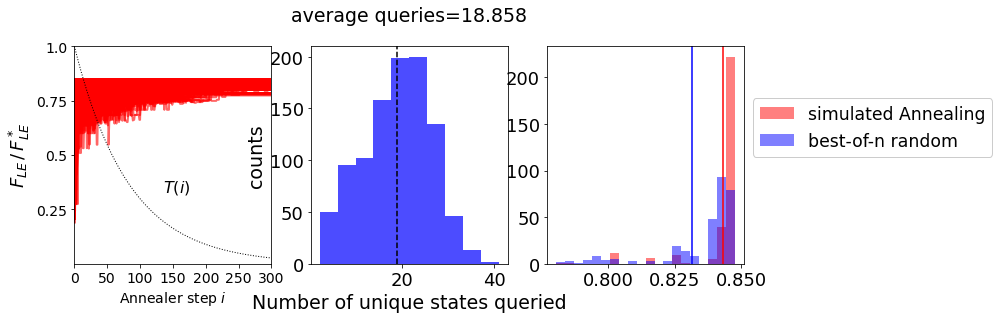

In [22]:

plt.style.use('../../style.mplstyle')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(ntrials):
    axes[0].plot(range(anneal_steps+1), anneal_outcomes[i,:], lw=2, alpha=0.6, c='r')
    
axes[0].plot(range(anneal_steps), demo_temp / max(demo_temp), linewidth=1, c='k', ls=':')
axes[0].set_xlim(-2, anneal_steps+2)
axes[0].set_xticks(range(0, anneal_steps+1, 50))
axes[0].set_xticklabels(range(0, anneal_steps+1, 50), fontsize=14)
axes[0].set_xlabel('Annealer step $i$', fontsize=14)

axes[0].set_ylim(0, max(results[:,0]))
axes[0].set_xlim(0, anneal_steps)
axes[0].set_yticks([.25, .5, .75, 1.])
axes[0].set_yticklabels([.25, .5, .75, 1.], fontsize=14)
axes[0].set_ylabel(r"$F_{LE} \,/ \,F_{LE}^*$", fontsize=18)

axes[0].text(135, 0.33, r"$T(i)$", size=16)


avg_unq_states = np.average(anneal_unq_states)
axes[1].hist(anneal_unq_states, color='b', alpha=0.7, bins=10)
axes[1].axvline(avg_unq_states, c='k', ls='--')
axes[1].set_title("average queries={}".format(avg_unq_states))
axes[1].set_xlabel("Number of unique states queried")
axes[1].set_ylabel("counts")


# Subplot1 (ax1): annealer histories with temperature overlay
# baseline_perf = np.average(found, axis=1)
baseline_perf = found.flatten()
annealer_perf = np.max(anneal_outcomes, axis=1).flatten()
# cts, bins, patches = axes[2].hist(FLE , bins=30, color='k', label=r"$p(F_{LE})$", density=True, alpha=0.5)
cts, bins, patches = axes[2].hist(annealer_perf, bins=20, color='r', density=True, label=r"simulated Annealing", alpha=0.5)
cts, bins, patches = axes[2].hist(baseline_perf, bins=bins, color='b', density=True, label=r"best-of-n random", alpha=0.5)
axes[2].axvline(np.average(baseline_perf), c='b')
axes[2].axvline(np.average(annealer_perf), c='r')
axes[2].legend(framealpha=1, bbox_to_anchor=(1, 0.8), loc="upper left")

In [26]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """This will truncate a colormap that assumes a [0, 1] range.

    After truncation, the color that formerly corresponded to `0` will correspond
    to `minval`, while the color that formerly corresponded to `1` will be
    represented by `maxval`.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


0.826174314710262
[1.82542269]
0.8401732072064204
[7.09780414]
0.8446408953595883
[8.78046269]


/tmp/ipykernel_7139/930634838.py:129: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.85)


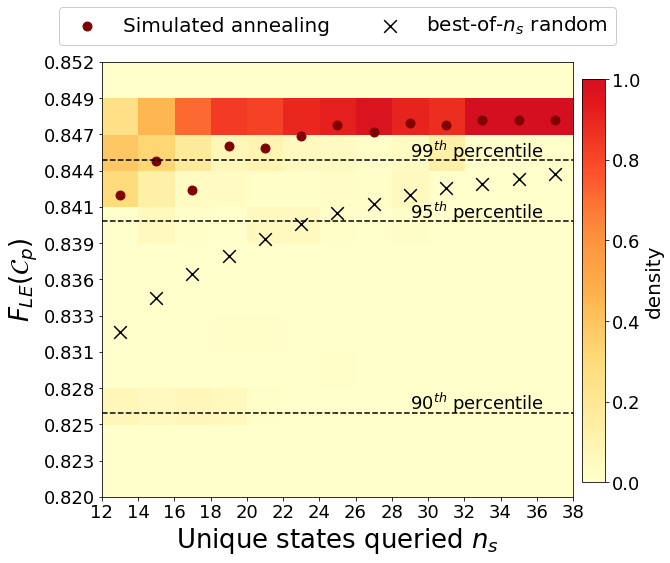

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True, constrained_layout = True)

axes = [ax]

anneal_best = np.max(anneal_outcomes, axis=1)
state_counts = np.unique(anneal_unq_states)

# Define hexbin grid extent
xmin = min(anneal_unq_states)
xmax = max(anneal_unq_states)
ymin = min(*anneal_best, *found.flatten())
ymax = max(*anneal_best, *found.flatten())

keeprange_x = [12, 38]
keeprange_y = [0.82, ymax*1.005]
ext = (keeprange_x[0], keeprange_x[1], keeprange_y[0], keeprange_y[1])
xbins = (ext[1] - ext[0] + 1) // 2

rand_counts_arr = np.tile(state_counts, ntrials_rand)


H_anneal, xedges, yedges = np.histogram2d(anneal_unq_states, 
                                   anneal_best, 
                                   range=[keeprange_x, keeprange_y], 
                                   bins=[xbins, 12])
H_anneal = H_anneal / H_anneal.sum(axis=1, keepdims=True)


base_cmap = 'YlOrRd'
cmap = truncate_colormap(plt.get_cmap(base_cmap), 0, 0.8)

im = axes[0].imshow(H_anneal.T, origin='lower', cmap=cmap)



# rand_counts_arr = np.tile(state_counts, ntrials_rand)
# H_rand, xedges_rand, yedges_rand = np.histogram2d(rand_counts_arr, 
#                                    found.flatten(order='F'), 
#                                    range=[keeprange_x, keeprange_y], 
#                                    bins=[xbins, 12])
# H_rand = H_rand / H_rand.sum(axis=1, keepdims=True)
# axes[1].imshow(H_rand.T, origin='lower', cmap='cividis')


xstride = 1
for ax in axes:
    # left-edge ticks (looks ugly.)
    x_idx_keep = np.arange(0, len(xedges), xstride)
    xticks = x_idx_keep - 0.5
    ax.set_xticks(xticks)
    ax.set_xticklabels(xedges.astype(int)[x_idx_keep])

    

    # Centered ticks (looks ugly?)
#     centered_ticks = xedges + 1
#     x_idx_keep = np.arange(1, len(xedges) - 1, xstride)
#     ax.set_xticks(x_idx_keep )
#     ax.set_xticklabels(centered_ticks.astype(int)[x_idx_keep])

ystride = 1
y_idx_keep = np.arange(0, len(yedges), ystride)
axes[0].set_yticks(y_idx_keep - 0.5)
yticklabels_fmt = np.asarray([f"{x:2.3f}" for x in yedges])[y_idx_keep]
axes[0].set_yticklabels(yticklabels_fmt)


# Overlay avg performance; need to generate statistics

# For each xtick value, we will interpolate an x position
# at which to overlay the average y-values, in imshow coords.
# These are in arbitrary coordinates, e.g. [0, 1, 2, 3, ...] and
# are an interpolation of arbitrary coordinates [-0.5, 0.5, 1.5, ...]
# which are in one-to-xstride correspondence with left cell edges
# (given as xedges[:-1])
xticks_interpolated = xticks[:-1] + np.diff(xticks)/2
xedges_interpolated = xedges[:-1] + np.diff(xedges)/2

# This isn't clean but should work: Grab the desired yvalues
# using xedges_interpolated as keys, but then do the 
# actual plotting with respect to xticks_interpolated
yvals = np.zeros(len(xedges_interpolated))
yvals_rand = np.zeros(len(xedges_interpolated))
for i, cts in enumerate(xedges_interpolated):
    slc = np.where(anneal_unq_states == cts)
    yvals[i] = np.average(anneal_best[slc])
    trial_num = np.where(state_counts == cts)
    yvals_rand[i] = np.average(found[trial_num,:])
# Last step is to transform yvals into the ytick coordinate
# system in a similar way. Now we don't do discrete interpolation,
# but instead try to transform an almost-continuous representation
# of the ytick coordinate system.
yticks = axes[0].get_yticks()
yticks_interpolated = yticks[:-1] + np.diff(yticks)/2
yedges_interpolated = yedges[:-1] + np.diff(yedges)/2
yticklabs = yedges[y_idx_keep]

def xform_yval_to_ytick_coords(yarr):
    ytick_delta = max(yticks_interpolated) - min(yticks_interpolated)
    yedge_delta = max(yedges_interpolated) - min(yedges_interpolated)
    return (yarr - min(yedges_interpolated)) * ytick_delta / yedge_delta + min(yticks_interpolated)

markersize = 80
axes[0].scatter(xticks_interpolated, xform_yval_to_ytick_coords(yvals), c='maroon', marker='o', s=markersize, label="Simulated annealing")
axes[0].scatter(xticks_interpolated, xform_yval_to_ytick_coords(yvals_rand), c='black', marker='x', s=2*markersize, label=r"best-of-$n_s$ random")
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), framealpha=1, ncol=2, prop={'size': 20} )

for ax in axes:
    ax.set_xlabel(r"Unique states queried $n_s$", size=26)
axes[0].set_ylabel(r"$F_{LE}(\mathcal{C}_p)$", size=26)


# axes[0].text(-0.05, 1.08, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=axes[0].transAxes, weight="bold")

# percentile overlays
for k in [90, 95, 99]:
    perc = np.percentile(FLE, k)
    print(perc)
    zzz = xform_yval_to_ytick_coords([perc])
    print(zzz)
    percentile_color = 'k'
    axes[0].axhline(zzz[0], c=percentile_color, ls='--')
    axes[0].text(8, zzz[0] + 0.1, f"{k}" + r"$^{th}$ percentile", size=18, c=percentile_color)

    
    
    
# colorbar  
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, )
cbar_ax.set_ylabel("density", size=20)


# DRAFT
import os
DRAFT = False
if DRAFT:
    axes[0].text(-.2,1.2, "/annealer_ghz_line_n4_scratchwork.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=axes[0].transAxes, weight="bold")
fig.savefig("../../figures/qftj_anneal_results.pdf",bbox_inches='tight')

